In [ ]:
import numpy as np
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix as csr
from scipy.sparse import lil_matrix as lil
from scipy.sparse import kron
from scipy.sparse.linalg import eigs, eigsh
import timeit
import scipy.sparse as sps
from numpy import linalg as LA

# **Infinite DMRG**

**4** **dimensional** **hilbert** **space**:

$|EmptySite> = $
$\begin{bmatrix}
1 \\
0 \\
0 \\
0 
\end{bmatrix}$
,
$|Up> = $
$\begin{bmatrix}
0 \\
1 \\
0 \\
0
\end{bmatrix}$
,
$|Down> = $
$\begin{bmatrix}
0 \\
0 \\
1 \\
0
\end{bmatrix}$
,
$|Doubleoccupancy> = $
$\begin{bmatrix}
0 \\
0 \\
0 \\
1
\end{bmatrix}$

In [ ]:
bc = 0 #boundary condition
t = 1
U = 0.2

n_kept_states = 15 # Number of states kept
system_size = 70

# Number of iterations.  Final lattice size is 2*n_iter + 2
n_iter = 34 #-> Final lattice size = 62


###########################################################
# Operators in 4 dimensional hilbert space for single site
###########################################################

# Creation and Annihilation Operators:
C_up = csr(np.array([[0,1,0,0], [0,0,0,0],[0,0,0,1],[0,0,0,0]]))
C_up_dag = csr(np.transpose(C_up))

C_down = csr(np.array([[0,0,1,0], [0,0,0,1],[0,0,0,0],[0,0,0,0]]))
C_down_dag = csr(np.transpose(C_down))

# Number Operators:
n_up = csr(np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,1]]))
n_down = csr(np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,1]]))
n = n_up + n_down

#Identity matrix
I = csr(np.eye(4))

############################################################################
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
############################################################################

# Operators for last site added to block 
block_Cu_last = C_up
block_Cud_last = C_up_dag
block_Cd_last = C_down
block_Cdd_last = C_down_dag
block_nu_last = n_up
block_nd_last = n_down
block_Id  = I

# one site Hamiltonian
block_H = U*(n_up*n_down)

# initializing a few useful quantities:
EE = np.zeros(n_iter)
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)

**2** **dimensional** **hilbert** **space**

In [ ]:
###########################################################
# Operators in 2 dimensional hilbert space for single site
###########################################################

# Creation and Annihilation Operators:
C = csr(np.array([[0,0],[1,0]])) #annihilation operator -> sigma_minus
C_dag = csr(np.transpose(C)) #creation operator -> sigma_plus

# Number Operator:
n = C_dag*C

#Identity matrix
I_d = csr(np.eye(2))
I = csr(np.eye(4))

############################################################################
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
############################################################################

#Each site is considered to be a unitcell that the left side is spin-down and the right side is spin-up

C_up = csr(kron(I_d,C))     #second site in unitcell
C_down = csr(kron(C,I_d))   #first site in unitcell

C_up_dag = csr.transpose(C_up)
C_down_dag = csr.transpose(C_down)
n_up = csr(kron(I_d,n))
n_down = csr(kron(n,I_d))

# Operators for last site added to block 
block_Cu_last = C_up
block_Cud_last = C_up_dag
block_Cd_last = C_down
block_Cdd_last = C_down_dag
block_nu_last = n_up
block_nd_last = n_down
block_Id  = kron(I_d,I_d)

# one site Hamiltonian
block_H = U*(n_up*n_down)

# initializing a few useful quantities:
EE = np.zeros(n_iter)
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)

# Saving operators for finite dmrg
block_Cu_list = []
block_Cud_list = []

block_Cd_list = []
block_Cdd_list = []

block_H_list = []
block_Id_list = []

block_Cu_list.append(block_Cu_last)
block_Cud_list.append(block_Cud_last)

block_Cd_list.append(block_Cd_last)
block_Cdd_list.append(block_Cdd_last)

block_H_list.append(block_H)
block_Id_list.append(block_Id)

We can label our hilbert space with 4 states. In this approach, for each iteration we add one site to the hamiltonian and each site will have four states: empty, spin-up, spin-down & double occupency.\
Another approach is to neglect spin at first so the hilbert space will have only two states: empty or occupied, the creation and annihilation operators are also $2\times 2$. But now we imagine that each site is like a unitcell with two sites which the left side is spin down and the right side in spin up so in this unitcell th first site is spin down and the second site is spin up. we can construct the spin up and spin down operators in one unitcell using kron product of $2\times 2$ Identity matrix with $2\times 2$ creation and annihilation operators.In this approach, for each iteration we add a unitcell (two sites) to the hamiltonian, the odd sites are spin down and the even sites are spin up.\
Same result is obtained from these two approaches.

In [ ]:
###############################
#   Begin main iterations
###############################

start = timeit.default_timer()
for l in range(n_iter):
    
    ##################################################################
    #       Get the 2*chi-dimensional operators for the block +
    #       site where chi = n_kept_states
    ##################################################################
    
    block_nu_last = kron(block_Id,n_up)
    block_nd_last = kron(block_Id,n_down)
    

    block_H = kron(block_H,I)-t*(kron(block_Cud_last,C_up) + kron(block_Cu_last,C_up_dag)\
                                 + kron(block_Cdd_last,C_down)+ kron(block_Cd_last,C_down_dag))\
    + U*(block_nu_last*block_nd_last)
    
    block_Cu_last = kron(block_Id,C_up)
    block_Cud_last = kron(block_Id,C_up_dag)
    block_Cd_last = kron(block_Id,C_down)
    block_Cdd_last = kron(block_Id,C_down_dag)
    block_Id = kron(block_Id,I)
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H,block_Id) + kron(block_Id, block_H)\
    -t*(kron(block_Cud_last,block_Cu_last) + kron(block_Cu_last,block_Cud_last)\
        + kron(block_Cdd_last,block_Cd_last) + kron(block_Cd_last,block_Cdd_last))
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2  #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    #last_energy = energy
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l] = energy/ ((l + 1) * 2 + 2)
    system_size[l] = 2*(2+l)
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block = np.size(block_H,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block, dim_block))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix))
    
    #########################################################################
    #   Diagonalize the density matrix and Calculating Entanglement Entropy
    #########################################################################
    
    n_kept_temp = min(dim_block, n_kept_states)
    D, V = LA.eigh(block_Rho)
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    ES = D
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l] = 1 - sum(ES[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l], truncation_error[l]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H  = block_T_dag*block_H*block_T
    block_Cu_last  = block_T_dag*block_Cu_last*block_T
    block_Cud_last = block_T_dag*block_Cud_last*block_T
    block_Cd_last = block_T_dag*block_Cd_last*block_T
    block_Cdd_last = block_T_dag*block_Cdd_last*block_T
    block_Id = block_T_dag*block_Id*block_T
    block_nu_last = block_T_dag*block_nu_last*block_T
    block_nd_last = block_T_dag*block_nd_last*block_T  
           
    ###################################
    # Saving operators for finite dmrg
    ###################################
    
    block_Cu_list.append(block_Cu_last)
    block_Cud_list.append(block_Cud_last)

    block_Cd_list.append(block_Cd_last)
    block_Cdd_list.append(block_Cdd_last)

    block_H_list.append(block_H)
    block_Id_list.append(block_Id)
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 0	 total_En: -4.2763	 En_per_bound: -1.0691	 trunErr: 0.0000
iter: 1	 total_En: -6.6933	 En_per_bound: -1.1156	 trunErr: 0.0022
iter: 2	 total_En: -9.1017	 En_per_bound: -1.1377	 trunErr: 0.0001
iter: 3	 total_En: -11.5333	 En_per_bound: -1.1533	 trunErr: 0.0038
iter: 4	 total_En: -13.9426	 En_per_bound: -1.1619	 trunErr: 0.0002
iter: 5	 total_En: -16.3770	 En_per_bound: -1.1698	 trunErr: 0.0041
iter: 6	 total_En: -18.7879	 En_per_bound: -1.1742	 trunErr: 0.0003
iter: 7	 total_En: -21.2228	 En_per_bound: -1.1790	 trunErr: 0.0041
iter: 8	 total_En: -23.6357	 En_per_bound: -1.1818	 trunErr: 0.0004
iter: 9	 total_En: -26.0706	 En_per_bound: -1.1850	 trunErr: 0.0039
iter: 10	 total_En: -28.4853	 En_per_bound: -1.1869	 trunErr: 0.0005
iter: 11	 total_En: -30.9201	 En_per_bound: -1.1892	 trunErr: 0.0038
iter: 12	 total_En: -33.3365	 En_per_bound: -1.1906	 trunErr: 0.0006
iter: 13	 total_En: -35.7712	 En_per_bound: -1.1924	 trunErr: 0.0036
iter: 14	 total_En: -38.1900	 En_per_bound: -1.

Plots



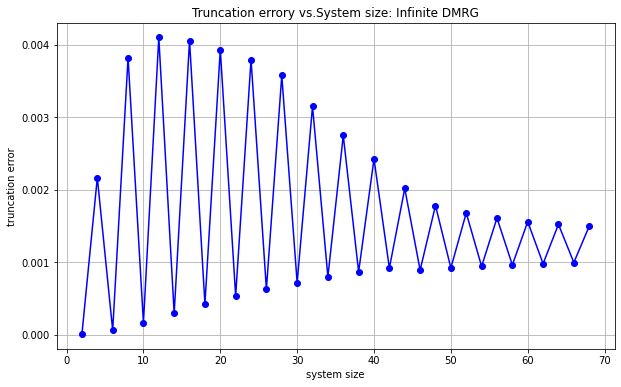

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(system_size,truncation_error,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('truncation error')
plt.title('Truncation errory vs.System size: Infinite DMRG')
plt.grid('on')

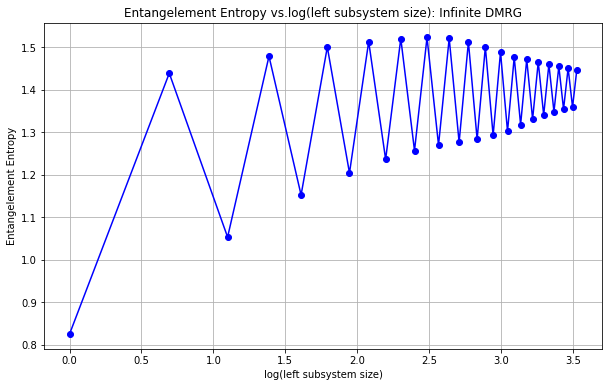

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.log(system_size/2),EE,'o-',c='b')
plt.xlabel('log(left subsystem size)')
plt.ylabel('Entangelement Entropy')
plt.title('Entangelement Entropy vs.log(left subsystem size): Infinite DMRG')
plt.grid('on')

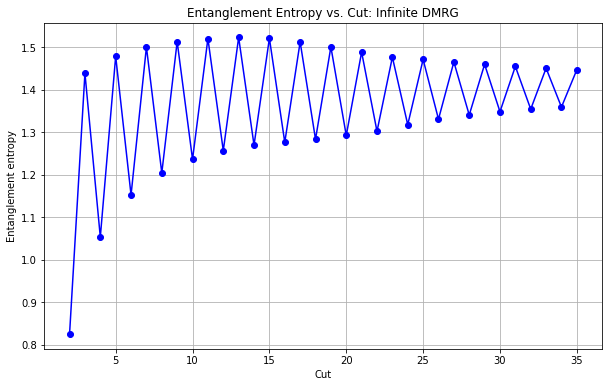

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(2,len(EE)+2), EE,'o-',c='b')
plt.title('Entanglement Entropy vs. Cut: Infinite DMRG')
plt.xlabel('Cut')
plt.ylabel('Entanglement entropy')
plt.grid('on')

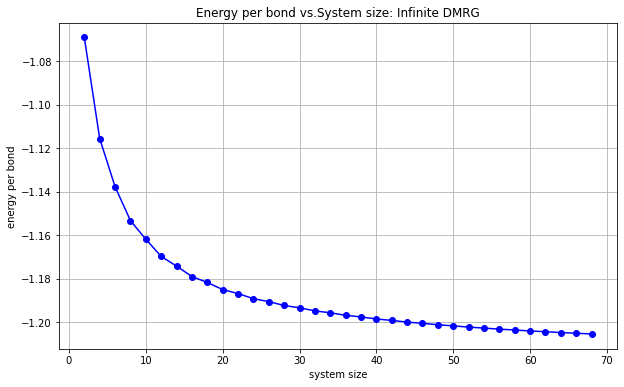

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(system_size,energy_per_bond,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('energy per bond')
plt.title('Energy per bond vs.System size: Infinite DMRG')
plt.grid('on')

# **Finite DMRG**

In [ ]:
#Loading operators for left block:
block_Cu_left = block_Cu_list[n_iter]
block_Cud_left = block_Cud_list[n_iter]

block_Cd_left = block_Cd_list[n_iter]
block_Cdd_left = block_Cdd_list[n_iter]

block_H_left = block_H_list[n_iter]
block_Id_left = block_Id_list[n_iter]

# **DMRG Sweeps**

**Left**-**to**-**Right** **Sweep**

In [ ]:
system_size = 2*n_iter + 2

###############################
#   Begin main iterations
###############################
n_iter_l = n_iter-1 #because there are already two sites in the system

truncation_error = np.zeros(n_iter_l)
energy_per_bond = np.zeros(n_iter_l)

start = timeit.default_timer()
for l in range(n_iter_l):
    
    ###########################
    #  Right block operators
    ###########################
    
    #Shrink the right block using the operators from infinite dmrg:
    block_H_right = block_H_list[n_iter - (l+2)]
    
    block_Cu_right = block_Cu_list[n_iter - (l+2)]
    block_Cud_right = block_Cud_list[n_iter - (l+2)]
    
    block_Cd_right = block_Cd_list[n_iter - (l+2)]
    block_Cdd_right = block_Cdd_list[n_iter - (l+2)]
    
    block_Id_right = block_Id_list[n_iter - (l+2)]
    
    #constructing the right block hamiltonian
    block_nu_right = kron(block_Id_right,n_up)
    block_nd_right = kron(block_Id_right,n_down)
    
    block_H_right = kron(block_H_right, I) -t*(kron(block_Cud_right,C_up) + kron(block_Cu_right,C_up_dag)\
                                              + kron(block_Cdd_right,C_down) + kron(block_Cd_right,C_down_dag))\
    + U*(block_nu_right*block_nd_right)
    
    block_Cu_right = kron(block_Id_right,C_up)
    block_Cud_right = kron(block_Id_right,C_up_dag)
    
    block_Cd_right = kron(block_Id_right,C_down)
    block_Cdd_right = kron(block_Id_right,C_down_dag)
    
    block_Id_right = kron(block_Id_right,I)
    
    ##############################
    #  Adding site to left block
    ##############################
    
    block_nu_left = kron(block_Id_left,n_up)
    block_nd_left = kron(block_Id_left,n_down)
    
    block_H_left = kron(block_H_left, I) -t*(kron(block_Cud_left,C_up) + kron(block_Cu_left,C_up_dag)\
                                              + kron(block_Cdd_left,C_down) + kron(block_Cd_left,C_down_dag))\
    + U*(block_nu_left*block_nd_left)
    
    block_Cu_left = kron(block_Id_left,C_up)
    block_Cud_left = kron(block_Id_left,C_up_dag)
    
    block_Cd_left = kron(block_Id_left,C_down)
    block_Cdd_left = kron(block_Id_left,C_down_dag)
    
    block_Id_left = kron(block_Id_left,I)
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right)\
    -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right)\
       +kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
    
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2 #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l] = energy/ system_size
    #system_size[l] = 2*(1+l)
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_left,axis=1)
    dim_block_right = np.size(block_H_right,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix)) #reduced density matrix
    
    #######################################
    #   Diagonalize the density matrix 
    #######################################
    
    D, V = LA.eigh(block_Rho)

    #sorting eigenvalues and their corresponding eigenvectors in descending order:
    sort_ind = np.argsort(D)[::-1] 
    V = V[:, sort_ind] 
    D = D[sort_ind]
    n_kept_temp = min(len(D), n_kept_states)
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp] #truncation operator
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l] = 1 - sum(D[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l], truncation_error[l]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H_left  = block_T_dag*block_H_left*block_T
    block_Cu_left  = block_T_dag*block_Cu_left*block_T
    block_Cud_left = block_T_dag*block_Cud_left*block_T
    block_Cd_left = block_T_dag*block_Cd_left*block_T
    block_Cdd_left = block_T_dag*block_Cdd_left*block_T
    block_Id_left = block_T_dag*block_Id_left*block_T
    
    ###################################
    # Saving operators for finite dmrg
    ###################################
    
    block_Cu_list.append(block_Cu_left)
    block_Cud_list.append(block_Cud_left)

    block_Cd_list.append(block_Cd_left)
    block_Cdd_list.append(block_Cdd_left)

    block_H_list.append(block_H_left)
    block_Id_list.append(block_Id_left)
    
stop = timeit.default_timer()
print('Time: ', stop - start)     

iter: 0	 total_En: -84.3816	 En_per_bound: -1.2055	 trunErr: 0.0010
iter: 1	 total_En: -84.3833	 En_per_bound: -1.2055	 trunErr: 0.0015
iter: 2	 total_En: -84.3816	 En_per_bound: -1.2055	 trunErr: 0.0010
iter: 3	 total_En: -84.3834	 En_per_bound: -1.2055	 trunErr: 0.0015
iter: 4	 total_En: -84.3817	 En_per_bound: -1.2055	 trunErr: 0.0010
iter: 5	 total_En: -84.3835	 En_per_bound: -1.2055	 trunErr: 0.0015
iter: 6	 total_En: -84.3818	 En_per_bound: -1.2055	 trunErr: 0.0010
iter: 7	 total_En: -84.3838	 En_per_bound: -1.2055	 trunErr: 0.0016
iter: 8	 total_En: -84.3820	 En_per_bound: -1.2055	 trunErr: 0.0010
iter: 9	 total_En: -84.3842	 En_per_bound: -1.2055	 trunErr: 0.0016
iter: 10	 total_En: -84.3823	 En_per_bound: -1.2055	 trunErr: 0.0009
iter: 11	 total_En: -84.3849	 En_per_bound: -1.2055	 trunErr: 0.0017
iter: 12	 total_En: -84.3829	 En_per_bound: -1.2055	 trunErr: 0.0009
iter: 13	 total_En: -84.3863	 En_per_bound: -1.2055	 trunErr: 0.0018
iter: 14	 total_En: -84.3838	 En_per_bound: 

In [ ]:
#Loading operators for right block:
block_Cu_right = block_Cu_list[0]
block_Cud_right = block_Cud_list[0]

block_Cd_right = block_Cd_list[0]
block_Cdd_right = block_Cdd_list[0]

block_H_right = block_H_list[0]
block_Id_right = block_Id_list[0]

 **Right-to-Left Sweep**

In [ ]:
n_iter_r = 2*n_iter_l+1 #from last sweep

truncation_error = np.zeros(n_iter_r)
energy_per_bond = np.zeros(n_iter_r)

###############################
#   Begin main iterations
###############################

start = timeit.default_timer()
for l in range(n_iter_r):
    
    #########################
    #  Left block operators
    #########################
    
    # using the left block operators from the privious left to right sweep:
    
    block_H_left = block_H_list[n_iter_r - (l+1)]
    
    block_Cu_left = block_Cu_list[n_iter_r - (l+1)]
    block_Cud_left = block_Cud_list[n_iter_r - (l+1)]
    
    block_Cd_left = block_Cd_list[n_iter_r - (l+1)]
    block_Cdd_left = block_Cdd_list[n_iter_r - (l+1)]
    
    block_Id_left = block_Id_list[n_iter_r - (l+1)]
    
    #Left block hamiltonian:
    
    block_nu_left = kron(block_Id_left,n_up)
    block_nd_left = kron(block_Id_left,n_down)
    
    block_H_left = kron(block_H_left, I) -t*(kron(block_Cud_left,C_up) + kron(block_Cu_left,C_up_dag)\
                                              + kron(block_Cdd_left,C_down) + kron(block_Cd_left,C_down_dag))\
    + U*(block_nu_left*block_nd_left)
    
    block_Cu_left = kron(block_Id_left,C_up)
    block_Cud_left = kron(block_Id_left,C_up_dag)
    
    block_Cd_left = kron(block_Id_left,C_down)
    block_Cdd_left = kron(block_Id_left,C_down_dag)
    
    block_Id_left = kron(block_Id_left,I)
    
    #########################################################
    #  Adding site to right block & right block hamiltonian
    #########################################################
    
    #Right block hamiltonian:
    block_nu_right = kron(block_Id_right,n_up)
    block_nd_right = kron(block_Id_right,n_down)
    
    block_H_right = kron(block_H_right, I) -t*(kron(block_Cud_right,C_up) + kron(block_Cu_right,C_up_dag)\
                                              + kron(block_Cdd_right,C_down) + kron(block_Cd_right,C_down_dag))\
    + U*(block_nu_right*block_nd_right)
    
    block_Cu_right = kron(block_Id_right,C_up)
    block_Cud_right = kron(block_Id_right,C_up_dag)
    
    block_Cd_right = kron(block_Id_right,C_down)
    block_Cdd_right = kron(block_Id_right,C_down_dag)
    
    block_Id_right = kron(block_Id_right,I)
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right)\
    -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right)\
       +kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
    
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2 #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l] = energy/system_size

    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_left,axis=1)
    dim_block_right = np.size(block_H_right,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    block_Rho = np.matmul(np.transpose(Psi_matrix),Psi_matrix)
    
    #######################################
    #   Diagonalize the density matrix 
    #######################################
    
    D, V = LA.eigh(block_Rho)
    #sorting eigenvalues and their corresponding eigenvectors in descending order:
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    n_kept_temp = min(len(D), n_kept_states)
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l] = 1 - sum(D[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l], truncation_error[l]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H_right  = block_T_dag*block_H_right*block_T
    block_Cu_right  = block_T_dag*block_Cu_right*block_T
    block_Cud_right = block_T_dag*block_Cud_right*block_T
    block_Cd_right = block_T_dag*block_Cd_right*block_T
    block_Cdd_right = block_T_dag*block_Cdd_right*block_T
    block_Id_right = block_T_dag*block_Id_right*block_T
    
    ###################################
    # Saving operators for finite dmrg
    ###################################
    
    block_Cu_list[l+1] = block_Cu_right
    block_Cud_list[l+1] = block_Cud_right

    block_Cd_list[l+1] = block_Cd_right
    block_Cdd_list[l+1] = block_Cdd_right

    block_H_list[l+1] = block_H_right
    block_Id_list[l+1] = block_Id_right
    
stop = timeit.default_timer()
print('Time: ', stop - start)       

iter: 0	 total_En: -84.4183	 En_per_bound: -1.2060	 trunErr: 0.0000
iter: 1	 total_En: -84.4244	 En_per_bound: -1.2061	 trunErr: 0.0022
iter: 2	 total_En: -84.4192	 En_per_bound: -1.2060	 trunErr: 0.0003
iter: 3	 total_En: -84.4257	 En_per_bound: -1.2061	 trunErr: 0.0026
iter: 4	 total_En: -84.4205	 En_per_bound: -1.2060	 trunErr: 0.0006
iter: 5	 total_En: -84.4263	 En_per_bound: -1.2061	 trunErr: 0.0024
iter: 6	 total_En: -84.4220	 En_per_bound: -1.2060	 trunErr: 0.0008
iter: 7	 total_En: -84.4264	 En_per_bound: -1.2061	 trunErr: 0.0022
iter: 8	 total_En: -84.4233	 En_per_bound: -1.2060	 trunErr: 0.0008
iter: 9	 total_En: -84.4273	 En_per_bound: -1.2061	 trunErr: 0.0019
iter: 10	 total_En: -84.4250	 En_per_bound: -1.2061	 trunErr: 0.0009
iter: 11	 total_En: -84.4286	 En_per_bound: -1.2061	 trunErr: 0.0018
iter: 12	 total_En: -84.4267	 En_per_bound: -1.2061	 trunErr: 0.0009
iter: 13	 total_En: -84.4299	 En_per_bound: -1.2061	 trunErr: 0.0017
iter: 14	 total_En: -84.4282	 En_per_bound: 

**Re**-**iterate** **left** **to** **right** **sweep** 

In [ ]:
#Loading operators left operators:
block_Cu_left = block_Cu_list[0]
block_Cud_left = block_Cud_list[0]

block_Cd_left = block_Cd_list[0]
block_Cdd_left = block_Cdd_list[0]

block_H_left = block_H_list[0]
block_Id_left = block_Id_list[0]

In [ ]:
truncation_error = np.zeros(n_iter_r)
energy_per_bond = np.zeros(n_iter_r)
EE = np.zeros(n_iter_r)
System_Size = np.zeros(n_iter_r)

for l in range(n_iter_r):
    
    ###########################
    #  Right block operators
    ###########################
    
    # using the right block from the privious right to left sweep:
    block_H_right = block_H_list[n_iter_r - (l+1)]
    
    block_Cu_right = block_Cu_list[n_iter_r - (l+1)]
    block_Cud_right = block_Cud_list[n_iter_r - (l+1)]
    
    block_Cd_right = block_Cd_list[n_iter_r - (l+1)]
    block_Cdd_right = block_Cdd_list[n_iter_r - (l+1)]
    
    block_Id_right = block_Id_list[n_iter_r - (l+1)]
    
    block_nu_right = kron(block_Id_right,n_up)
    block_nd_right = kron(block_Id_right,n_down)
    
    block_H_right = kron(block_H_right, I) -t*(kron(block_Cud_right,C_up) + kron(block_Cu_right,C_up_dag)\
                                              + kron(block_Cdd_right,C_down) + kron(block_Cd_right,C_down_dag))\
    + U*(block_nu_right*block_nd_right)
    
    block_Cu_right = kron(block_Id_right,C_up)
    block_Cud_right = kron(block_Id_right,C_up_dag)
    
    block_Cd_right = kron(block_Id_right,C_down)
    block_Cdd_right = kron(block_Id_right,C_down_dag)
    
    block_Id_right = kron(block_Id_right,I)
    
    ##############################
    #  Adding site to left block
    ##############################
    
    block_nu_left = kron(block_Id_left,n_up)
    block_nd_left = kron(block_Id_left,n_down)
    
    block_H_left = kron(block_H_left, I) -t*(kron(block_Cud_left,C_up) + kron(block_Cu_left,C_up_dag)\
                                              + kron(block_Cdd_left,C_down) + kron(block_Cd_left,C_down_dag))\
    + U*(block_nu_left*block_nd_left)
    
    block_Cu_left = kron(block_Id_left,C_up)
    block_Cud_left = kron(block_Id_left,C_up_dag)
    
    block_Cd_left = kron(block_Id_left,C_down)
    block_Cdd_left = kron(block_Id_left,C_down_dag)
    
    block_Id_left = kron(block_Id_left,I)
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right)\
    -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right)\
       +kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
    
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2  #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l] = energy/ system_size
    System_Size[l] = 2*(1+l)
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_left,axis=1)
    dim_block_right = np.size(block_H_right,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix))
    
    #######################################
    #   Diagonalize the density matrix 
    #######################################
    
    D, V = LA.eigh(block_Rho)
    #sorting eigenvalues and their corresponding eigenvectors in descending order:
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    ES = D
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    n_kept_temp = min(len(D), n_kept_states)
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l] = 1 - sum(D[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l], truncation_error[l]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H_left  = block_T_dag*block_H_left*block_T
    block_Cu_left  = block_T_dag*block_Cu_left*block_T
    block_Cud_left = block_T_dag*block_Cud_left*block_T
    block_Cd_left = block_T_dag*block_Cd_left*block_T
    block_Cdd_left = block_T_dag*block_Cdd_left*block_T
    block_Id_left = block_T_dag*block_Id_left*block_T
    
stop = timeit.default_timer()
print('Time: ', stop - start)  

iter: 0	 total_En: -84.4949	 En_per_bound: -1.2071	 trunErr: 0.0000
iter: 1	 total_En: -84.5005	 En_per_bound: -1.2071	 trunErr: 0.0020
iter: 2	 total_En: -84.4959	 En_per_bound: -1.2071	 trunErr: 0.0004
iter: 3	 total_En: -84.5010	 En_per_bound: -1.2072	 trunErr: 0.0021
iter: 4	 total_En: -84.4973	 En_per_bound: -1.2071	 trunErr: 0.0007
iter: 5	 total_En: -84.5007	 En_per_bound: -1.2072	 trunErr: 0.0019
iter: 6	 total_En: -84.4977	 En_per_bound: -1.2071	 trunErr: 0.0008
iter: 7	 total_En: -84.5006	 En_per_bound: -1.2072	 trunErr: 0.0018
iter: 8	 total_En: -84.4983	 En_per_bound: -1.2071	 trunErr: 0.0008
iter: 9	 total_En: -84.5007	 En_per_bound: -1.2072	 trunErr: 0.0016
iter: 10	 total_En: -84.4991	 En_per_bound: -1.2071	 trunErr: 0.0009
iter: 11	 total_En: -84.5012	 En_per_bound: -1.2072	 trunErr: 0.0015
iter: 12	 total_En: -84.5003	 En_per_bound: -1.2071	 trunErr: 0.0009
iter: 13	 total_En: -84.5023	 En_per_bound: -1.2072	 trunErr: 0.0014
iter: 14	 total_En: -84.5022	 En_per_bound: 

Plots

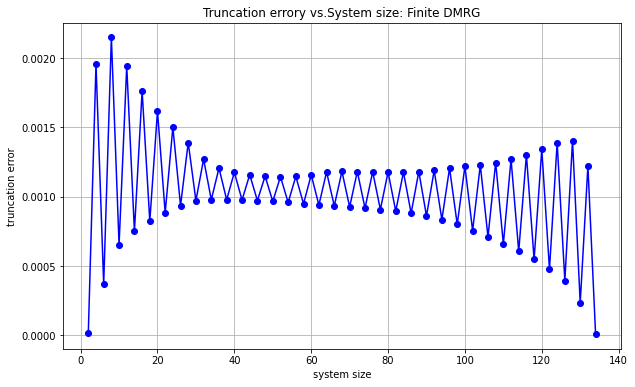

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(System_Size,truncation_error,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('truncation error')
plt.title('Truncation errory vs.System size: Finite DMRG')
plt.grid('on')

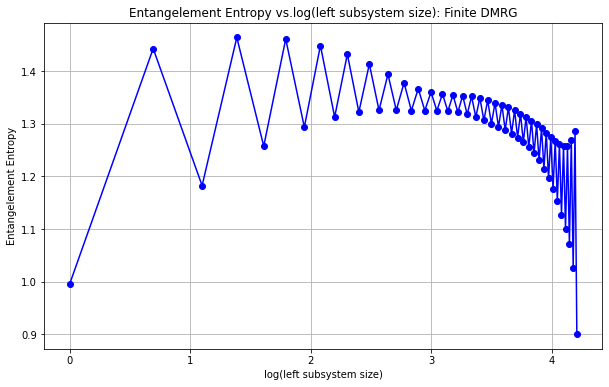

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.log(System_Size/2),EE,'o-',c='b')
plt.xlabel('log(left subsystem size)')
plt.ylabel('Entangelement Entropy')
plt.title('Entangelement Entropy vs.log(left subsystem size): Finite DMRG')
plt.grid('on')

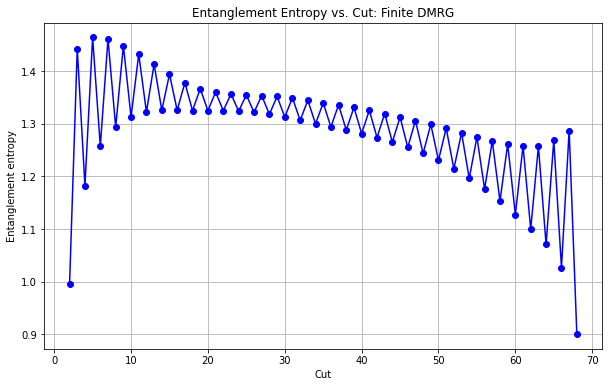

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(2,len(EE)+2), EE,'o-',c='b')
plt.title('Entanglement Entropy vs. Cut: Finite DMRG')
plt.xlabel('Cut')
plt.ylabel('Entanglement entropy')
plt.grid('on')

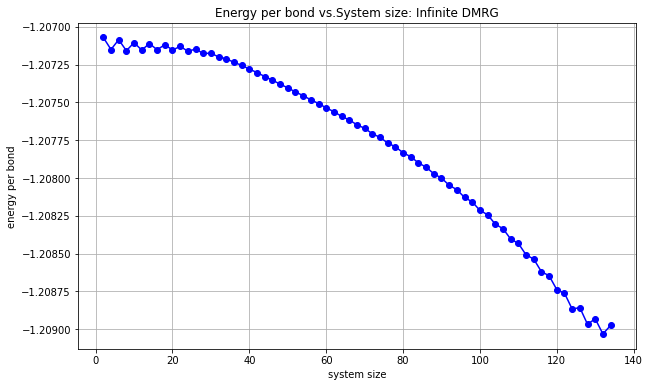

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(System_Size,energy_per_bond,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('energy per bond')
plt.title('Energy per bond vs.System size: Infinite DMRG')
plt.grid('on')
